In [1]:
from cuml.cluster import KMeans
import numpy as np
from sklearn.datasets import fetch_openml
#from keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cudf
import pickle

2024-07-22 02:39:26.300096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 02:39:26.318184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 02:39:26.323712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 02:39:26.338151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 02:39:27.165561: W tensorflow/compiler/tf2

# IMPORT DATA

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

X_reshape = X.values.reshape(-1, 28, 28)
X_reshape = np.expand_dims(X_reshape, -1)

def extract_patches(images, patch_size):
    patches = tf.image.extract_patches(images=images,
                                        sizes=[1, patch_size, patch_size, 1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')
    return patches
def extract_patches_batch(images, batch_size=256, patch_size=5):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.batch(batch_size)
    patches_list = []
    for batch in dataset:
        patches = extract_patches(batch, patch_size)
        patches_list.append(patches)
    return tf.concat(patches_list, axis=0)

X_patches = extract_patches_batch(X_reshape)

print(X_patches.shape)
def reshape_patches(patches):
    num_patches = patches.shape[0] * patches.shape[1] * patches.shape[2]
    patches = tf.reshape(patches, [num_patches, patches.shape[3]])
    return patches

flat_patches = reshape_patches(X_patches)
print(flat_patches.shape)

2024-07-22 02:39:33.200140: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-22 02:39:34.519785: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(70000, 24, 24, 25)
(40320000, 25)


# GENERATE MODEL

In [ ]:
X_cudf = cudf.DataFrame.from_records(flat_patches.numpy())

In [ ]:
k = 2500

kmeans = KMeans(n_clusters=k)
kmeans.fit(X_cudf)

labels = kmeans.labels_

In [ ]:
# SAVE MODEL
with open(f'kmeans_mnist_k{k}.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# ANALYZING MODEL

In [ ]:
# LOAD MODEL
with open("kmeans_mnist_k1000.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
label_data = model.labels_.to_numpy()
centroids = model.cluster_centers_.to_pandas().values

print(type(label_data), len(label_data))

In [ ]:
print('label:', y[(int) (5776419/576)])
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(flat_patches[5776419].numpy().reshape(5,5), cmap = 'gray', vmin=0, vmax=255)
axes[1].imshow(X_numpy[(int) (5776419/576)].reshape(28,28), cmap = 'gray', vmin=0, vmax=255)
plt.show()

In [ ]:
# Show all centroids
n = 10
fig, axes = plt.subplots(n, n, figsize=(18, 20))

for row in range(n):
    for col in range(n):
        loc = row*10 + col
        image = centroids[loc].reshape(5,5)
        axes[row][col].imshow(image, cmap='gray', vmin=0, vmax=255)
        axes[row][col].set_title(f'{loc}')
        axes[row][col].axis('off')
plt.show()

# ISOLATING CLUSTERS

In [ ]:
def isolate_cluster(label, labels, data):
    cluster_data = []
    for i in range(len(labels)):
        if labels[i] == label:
            cluster_data.append((data[i], i))
    return cluster_data

In [ ]:
cluster_data = isolate_cluster(2, label_data, flat_patches)

In [ ]:
import random as rand

X_numpy = X.values
n = 5
fig, axes = plt.subplots(n, n, figsize=(10, 10))

for row in range(n):
    for col in range(n):
        pick = rand.choice(cluster_data)
        image = pick[0].numpy().reshape(5,5)
        axes[row][col].imshow(image, cmap='gray', vmin=0, vmax=255)
        axes[row][col].set_title(f'{pick[1]}')
        axes[row][col].axis('off')
plt.show()

# RECONSTRUCTING NUMBER FROM CENTROIDS

In [ ]:
#choose an image:
image_index = 3
print('label:', y[image_index])
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(flat_patches[image_index*576 + 60 + 24*3].numpy().reshape(5,5), cmap = 'gray', vmin=0, vmax=255)
axes[1].imshow(X_numpy[image_index].reshape(28,28), cmap = 'gray')
axes[0].axis("off")
axes[1].axis("off")

plt.show()

In [ ]:
answer = model.predict(flat_patches[image_index*576:(image_index+1) * 576].numpy())
plt.hist(answer, 100)
plt.ylim(0, 20)
plt.show()

In [ ]:
centroid_cnt = np.bincount(answer)
sorted_indices = np.argsort(centroid_cnt)[::-1]
print(sorted_indices)

In [ ]:
fig, axes = plt.subplots(24, 24, figsize=(20, 25))
for row in range(0, 24):
    for col in range(0, 24):
        loc = answer[row*24 + col]
        axes[row][col].imshow(centroids[loc].reshape(5,5), cmap = 'gray', vmin=0, vmax=255)
        axes[row][col].set_title(f'{loc}')
        axes[row][col].axis('off')
plt.show()

# WHAT ARE THE SIZES OF THE CLUSTERS?

In [ ]:
# Show all centroids in order from most classifications to least
counts = np.bincount(label_data)
sorted_indices = np.argsort(counts)[::-1]

n = 10
fig, axes = plt.subplots(n, n, figsize=(18, 20))

for row in range(n):
    for col in range(n):
        loc = sorted_indices[999 - (row*10 + col)]
        image = centroids[loc].reshape(5,5)
        axes[row][col].imshow(image, cmap='gray', vmin=0, vmax=255)
        axes[row][col].set_title(f'{loc}')
        axes[row][col].axis('off')
plt.show()

# CALCULATE THE STANDARD DEVIATION OF THE MODEL, OR TRY TO SEE THE LOSS

In [3]:
with open("kmeans_mnist_k100.pkl", "rb") as f:
    k100 = pickle.load(f)
with open("kmeans_mnist_k500.pkl", "rb") as f:
    k500 = pickle.load(f)
with open("kmeans_mnist_k1000.pkl", "rb") as f:
    k1000 = pickle.load(f)
with open("kmeans_mnist_k1500.pkl", "rb") as f:
    k1500 = pickle.load(f)
with open("kmeans_mnist_k2000.pkl", "rb") as f:
    k2000 = pickle.load(f)
with open("kmeans_mnist_k2500.pkl", "rb") as f:
    k2500 = pickle.load(f)
with open("kmeans_mnist_k3000.pkl", "rb") as f:
    k3000 = pickle.load(f)
label_k100 = k100.labels_.to_numpy()
centroids_k100 = k100.cluster_centers_.to_pandas().values
label_k500 = k500.labels_.to_numpy()
centroids_k500 = k500.cluster_centers_.to_pandas().values
label_k1000 = k1000.labels_.to_numpy()
centroids_k1000 = k1000.cluster_centers_.to_pandas().values
label_k1500 = k1500.labels_.to_numpy()
centroids_k1500 = k1500.cluster_centers_.to_pandas().values
label_k2000 = k2000.labels_.to_numpy()
centroids_k2000 = k2000.cluster_centers_.to_pandas().values
label_k2500 = k2500.labels_.to_numpy()
centroids_k2500 = k2500.cluster_centers_.to_pandas().values
label_k3000 = k3000.labels_.to_numpy()
centroids_k3000 = k3000.cluster_centers_.to_pandas().values

In [4]:
import numpy as np

def standard_deviation(labels, centroids):
    diffs = centroids[labels] - flat_patches
    norms = np.linalg.norm(diffs, axis=1)
    nstd = np.zeros(len(centroids))
    np.add.at(nstd, labels, norms)
    counts = np.bincount(labels)
    counts = np.maximum(counts, 1)
    std = nstd / counts
    return std

# Use the function
stdk100arr = standard_deviation(label_k100, centroids_k100)
stdk500arr = standard_deviation(label_k500, centroids_k500)
stdk1000arr = standard_deviation(label_k1000, centroids_k1000)
stdk1500arr = standard_deviation(label_k1500, centroids_k1500)
stdk2000arr = standard_deviation(label_k2000, centroids_k2000)
stdk2500arr = standard_deviation(label_k2500, centroids_k2500)
stdk3000arr = standard_deviation(label_k3000, centroids_k3000)


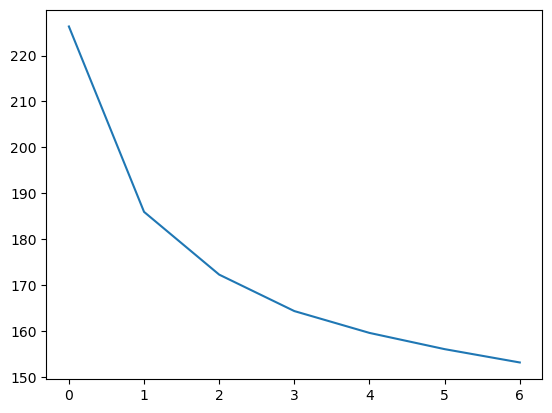

In [5]:
holdthis = [np.mean(stdk100arr), np.mean(stdk500arr), np.mean(stdk1000arr), np.mean(stdk1500arr), np.mean(stdk2000arr), np.mean(stdk2500arr), np.mean(stdk3000arr)]
plt.plot(holdthis)
plt.show()